In [119]:
import pickle as cPickle
import gzip
import random

import numpy as np
%pylab inline 
import pylab as pl # библиотека для построения графиков

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [120]:
def load_data():
    '''
    traning_data - массив из 50000 тренировочных примеров, 
    0 - элемент содержит массив массивов бит изображений
    1 - соответствующий картинке номер
    validation_data и test_data аналогичные, но содержат 
    по 10000 значений
    '''
    f = gzip.open('./data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = cPickle.load(f,encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

In [121]:
training, validation, test = load_data()

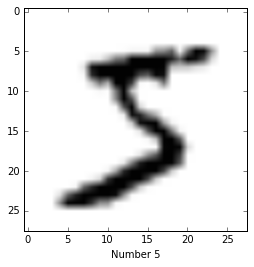

In [122]:
test = np.reshape(training[0][0],(28,28))
pl.imshow(test,cmap='Greys')
pl.xlabel(('Number %d' % training[1][0]))

In [123]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [137]:
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_zipped = zip(test_inputs, te_d[1])
    return (training_data, validation_data,test_zipped)

In [125]:
def sigmoid(z):
    """Вычисление сигмоидальной функции"""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Производная сигмоидальной функции"""
    return sigmoid(z)*(1-sigmoid(z))

In [168]:
class Network(object):

    def __init__(self, sizes):
        """sizez - список, содержащий число нейронов 
        на различных слоях сети. 
        К примеру, если size=[2, 3, 1], то будет создана 
        трехслойная сеть. С первым слоем из двух нейронов, вторым слоем 3
        И одним выходным нейроном. Веса генерируются случайным образом.
        Первый слой является входным, поэтому к нему не устанавливается 
        порог активации (bias)
        """
        self.num_layers = len(sizes) # число слоев
        self.sizes = sizes 
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        #print(self.biases)
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        #print(self.weights)
    
    def prettySchema(self):
        '''ToDo - вывести схему'''
        next
        #print('biases={}'.format(self.biases))
        #print('weights={}'.format(self.weights))
        
    def feedforward(self, a):
        """Осуществляет прямое распространение сигнала"""
        for b, w in zip(self.biases, self.weights): 
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """
        Реализация стохастического градиентного спуска
        ``training_data`` это список пар ``(x, y)``,
        представляющих вход и желаемый выход
        ``epochs`` - число эпох обучения (сколько итераций 
        происходит при обучении)
        """
        if test_data: 
            n_test = len(list(test_data))
        n = len((list(training_data)))
        for j in range(epochs):
            training_data = list(training_data)
            random.shuffle(training_data)
            training_data = zip(*training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print ("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))    
    
    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)


In [164]:
(training_data,validation_data,test_data)=load_data_wrapper()
training_data = list(training_data)
random.shuffle(training_data)
training_data = zip(*training_data)

In [167]:
net = Network([784, 30, 10])
net.SGD(training_data, 30, 10, 3.0, test_data=test_data)

AttributeError: 'Network' object has no attribute 'evaluate'

In [129]:
x = [1, 2, 3]
y = [4, 5, 6]
zipped = zip(x, y)
len(list(zipped))

3

In [160]:
a = ['a', 'b', 'c']
b = [1, 2, 3]

c = list(zip(a, b))
print(c)
print(*c)

random.shuffle(c)
a, b = zip(*c)

print( a)
print(b)

[('a', 1), ('b', 2), ('c', 3)]
('a', 1) ('b', 2) ('c', 3)
('c', 'b', 'a')
(3, 2, 1)
